# imports

In [ ]:
from utils import *

NOTEBOOK_ID = '03'
RUN_ESM = False
RUN_MODELS = False

# embed sequences

In [14]:
if RUN_ESM:
    hummel_df = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_Activity_500k_Rat.csv')[['AAseq','Activity_500k_Rat']]

    tmp_df = hummel_df.copy().rename(columns={'Activity_500k_Rat':'activity'})
    tmp_df['ID'] = ['hummel-' + str(i).zfill(5) for i in hummel_df.index]
    tmp_df = tmp_df[['ID','AAseq','activity']]
    if not os.path.isfile(f'{TARGET_DIR}/01-dataset/hummel.faa'):
        df_to_fasta(tmp_df,'ID','AAseq',f'{TARGET_DIR}/01-dataset/hummel.faa')
    for model,layer in ESM_MODELS.items():
        if model == 'esm2_t48_15B_UR50D':
            continue
        print(model)
        for test_layer in ['first_layer','last_layer']:
            if test_layer == 'last_layer':
                curr_layer = layer
            else:
                curr_layer = 0
            print(f'current layer: {curr_layer}')

            if not os.path.isfile(f'{EMBEDDING_DIR}/01-dataset/{model}-layer{curr_layer}-representations.pkl'):
                if not os.path.exists(f'{EMBEDDING_DIR}/01-dataset/{model}/{curr_layer}'):
                    os.makedirs(f'{EMBEDDING_DIR}/01-dataset/{model}/{curr_layer}')
                print('running ESM')
                run_esm(f'{TARGET_DIR}/01-dataset/hummel.faa',
                        f'{EMBEDDING_DIR}/01-dataset/{model}/{curr_layer}',
                        model=model,
                        layer=curr_layer)
                
                print('saving representations')
                embedding_df = tmp_df.copy()
                embedding_df[model] = embedding_df['ID'].apply(lambda x: get_embedding(f'{EMBEDDING_DIR}/01-dataset/{model}/{curr_layer}',
                                                                                       x,
                                                                                       layer=curr_layer))
                embedding_df[['ID',model,'AAseq','activity']].to_pickle(f'{EMBEDDING_DIR}/01-dataset/{model}-layer{curr_layer}-representations.pkl')
                del embedding_df

# train/test embeddings

In [15]:
# take one model's embeddings and try 1) scaling y with minmax, standardscaler, both (2) scaling X with minmax, standardscaler, both
if RUN_MODELS:
    model = 'esm2_t33_650M_UR50D'
    curr_layer = 33

    curr_model = f'{model}-layer{curr_layer}'
    df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/{curr_model}-representations.pkl')
    X = np.asarray([np.array(emb) for emb in df[model]])
    y = df['activity'].to_numpy()
    threshold = df['activity'].median()

    for y_scaler in ['minmax','standard','both']:
        for x_scaler in ['minmax','standard','both']:
            dataset, _ = split_dataset(X,y,threshold,version='v2',scaler=y_scaler)
            train_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='hummel_'+y_scaler+curr_model,version='v2',random_state=1)
            test_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='hummel_'+y_scaler+curr_model,version='v2',random_state=1)
            
            X = preprocess_tensor(X,scaler=x_scaler)
            dataset, _ = split_dataset(X,y,threshold,version='v2',scaler=y_scaler)
            train_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='hummel_'+y_scaler+curr_model+'_scaledX'+x_scaler,version='v2',random_state=1)
            test_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='hummel_'+y_scaler+curr_model+'_scaledX'+x_scaler,version='v2',random_state=1)

In [16]:
# compare performance on test dataset when trained on first or last layer embeddings (i.e., is ESM learning anything from the protein sequences?)
if RUN_MODELS:
    for model,layer in ESM_MODELS.items():
        if model == 'esm2_t48_15B_UR50D':
            continue
        for curr_layer in [0, layer]:
            curr_model = f'{model}-layer{curr_layer}'
            df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/{curr_model}-representations.pkl')
            X = np.asarray([np.array(emb) for emb in df[model]])
            y = df['activity'].to_numpy()
            threshold = df['activity'].median()
            for state in range(1,4):
                if not os.path.isfile(f'{EMBEDDING_DIR}/02-evaluate/03-results/ADhunter_v2-hummel_{curr_model}_state{state}_test_df.pkl'):
                    dataset, _ = split_dataset(X,y,threshold,version='v2',scaler='standard',random_state=state)
                    train_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='hummel_'+curr_model,version='v2',random_state=state)
                    test_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='hummel_'+curr_model,version='v2',random_state=state)

In [17]:
# compare performance on test dataset when trained on first or last layer embeddings (i.e., is ESM learning anything from the protein sequences?)
if RUN_MODELS:
    for model,layer in ESM_MODELS.items():
        if model == 'esm2_t48_15B_UR50D':
            continue
        for curr_layer in [0, layer]:
            curr_model = f'{model}-layer{curr_layer}'
            df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/{curr_model}-representations.pkl')
            X = np.asarray([np.array(emb) for emb in df[model]])
            y = df['activity'].to_numpy()
            threshold = df['activity'].median()
            for state in range(1,2):
                if not os.path.isfile(f'{EMBEDDING_DIR}/02-evaluate/03-results/ADhunter_v2-cnn_{curr_model}_state{state}_test_df.pkl'):
                    dataset, _ = split_dataset(X,y,threshold,version='v2',scaler='standard',random_state=state)
                    train_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='cnn_'+curr_model,version='v2',random_state=state,num_res_blocks=0)
                    test_ADhunter(dataset,out_dir=f'{EMBEDDING_DIR}/02-evaluate',out_name='cnn_'+curr_model,version='v2',random_state=state,num_res_blocks=0)

# evaluate embeddings

In [18]:
# evaluate X and y scaling
_, test_df = parse_results(f'{EMBEDDING_DIR}/02-evaluate/03-results')
test_df = test_df[test_df['params'].apply(lambda x: 'dedup' not in x)]
test_df['params'] = test_df['params'].apply(lambda x: x.replace('hummel_','').replace('ADhunter_v2-',''))
test_df['layer'] = test_df['params'].apply(lambda x: x.split('-layer')[-1])
test_df['representation'] = test_df['params'].apply(lambda x: x.split('-layer')[0])
test_df['scaled'] = test_df['params'].apply(lambda x: 'scaled' in x)
test_df
# scaling_df = test_df[test_df['params'].apply(lambda x: 'esm' not in x[:3] and 'esm' in x)]
# calculate_metrics_from_df(scaling_df).sort_values('pearson_corr')

,y_test_hat,y_test,y_bin_test,best_thresh,params,layer,representation,scaled
3492,-0.744516,-0.622498,0.0,-0.094719,esm2_t6_8M_UR50D-layer0_scaledX_state1,0_scaledX_state1,esm2_t6_8M_UR50D,True
3493,0.079840,1.896690,1.0,-0.094719,esm2_t6_8M_UR50D-layer0_scaledX_state1,0_scaledX_state1,esm2_t6_8M_UR50D,True
3494,-1.429083,-1.467772,0.0,-0.094719,esm2_t6_8M_UR50D-layer0_scaledX_state1,0_scaledX_state1,esm2_t6_8M_UR50D,True
3495,-0.260479,0.372323,1.0,-0.094719,esm2_t6_8M_UR50D-layer0_scaledX_state1,0_scaledX_state1,esm2_t6_8M_UR50D,True
3496,-0.657607,-0.417336,0.0,-0.094719,esm2_t6_8M_UR50D-layer0_scaledX_state1,0_scaledX_state1,esm2_t6_8M_UR50D,True
...,...,...,...,...,...,...,...,...
364963,-1.081947,-0.757304,0.0,-0.149988,esm2_t6_8M_UR50D-layer0_scaledX_state3,0_scaledX_state3,esm2_t6_8M_UR50D,True
364964,-0.043766,-0.064150,1.0,-0.149988,esm2_t6_8M_UR50D-layer0_scaledX_state3,0_scaledX_state3,esm2_t6_8M_UR50D,True
364965,1.149846,-0.045943,1.0,-0.149988,esm2_t6_8M_UR50D-layer0_scaledX_state3,0_scaledX_state3,esm2_t6_8M_UR50D,True
364966,-0.394558,-0.673779,0.0,-0.149988,esm2_t6_8M_UR50D-layer0_scaledX_state3,0_scaledX_state3,esm2_t6_8M_UR50D,True


In [19]:
# evaluate 3D ESM
esm_df = test_df[test_df['params'].apply(lambda x: 'esm' in x[:3] and 'mean' not in x and 'scaled' not in x and 'quantized' not in x)].copy()
esm_df['state'] = esm_df['layer'].apply(lambda x: x.split('state')[-1])
esm_df['layer'] = esm_df['layer'].apply(lambda x: x.split('_')[0])
esm_df['params'] = esm_df['params'].apply(lambda x: x.split('-')[0])
esm_df = esm_df.groupby(['params','layer','state'])[['y_test_hat','y_test']].agg(lambda x: list(x))
esm_df['pearson_r'] = esm_df.apply(lambda x: pearsonr(x['y_test_hat'],x['y_test'])[0],axis=1)
esm_df['rmse'] = esm_df.apply(lambda x: mean_squared_error(x['y_test_hat'],x['y_test'],squared=False),axis=1)
esm_df = esm_df.drop(columns=['y_test_hat','y_test']).reset_index()
esm_df['is_first_layer'] = esm_df['layer'].apply(lambda x: x == '0').map({True:'First',False:'Last'})
esm_df

,params,layer,state,pearson_r,rmse,is_first_layer
0,esm1v_t33_650M_UR90S_1,0,1,0.623669,0.785628,First
1,esm1v_t33_650M_UR90S_1,0,2,0.676420,0.718297,First
2,esm1v_t33_650M_UR90S_1,0,3,0.657856,0.756121,First
3,esm1v_t33_650M_UR90S_1,33,1,0.737525,0.680559,Last
4,esm1v_t33_650M_UR90S_1,33,2,0.753825,0.639000,Last
5,esm1v_t33_650M_UR90S_1,33,3,0.729125,0.687026,Last
6,esm1v_t33_650M_UR90S_2,0,1,0.692901,0.725160,First
7,esm1v_t33_650M_UR90S_2,0,2,0.680166,0.714301,First
8,esm1v_t33_650M_UR90S_2,0,3,0.675971,0.743276,First
9,esm1v_t33_650M_UR90S_2,33,1,0.713170,0.705479,Last


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

esm2_t6_8M_UR50D_First vs. esm2_t6_8M_UR50D_Last: t-test independent samples, P_val:8.254e-01 t=-2.355e-01
esm2_t36_3B_UR50D_First vs. esm2_t36_3B_UR50D_Last: t-test independent samples, P_val:2.307e-01 t=1.412e+00
esm1v_t33_650M_UR90S_2_First vs. esm1v_t33_650M_UR90S_2_Last: t-test independent samples, P_val:1.125e-02 t=-4.449e+00
esm1v_t33_650M_UR90S_1_First vs. esm1v_t33_650M_UR90S_1_Last: t-test independent samples, P_val:6.849e-03 t=-5.128e+00
esm1v_t33_650M_UR90S_3_First vs. esm1v_t33_650M_UR90S_3_Last: t-test independent samples, P_val:5.411e-03 t=-5.477e+00
esm1v_t33_650M_UR90S_4_First vs. esm1v_t33_650M_UR90S_4_Last: t-test independent samples, P_val:2.647e-03 t=-6.655e+00
esm1v_t33_650M_UR90S_5_First vs. esm1v_t33_650M_UR90S_5_Last: t-test independent samples, P_val:7.489e-02 t=-2.393e+0

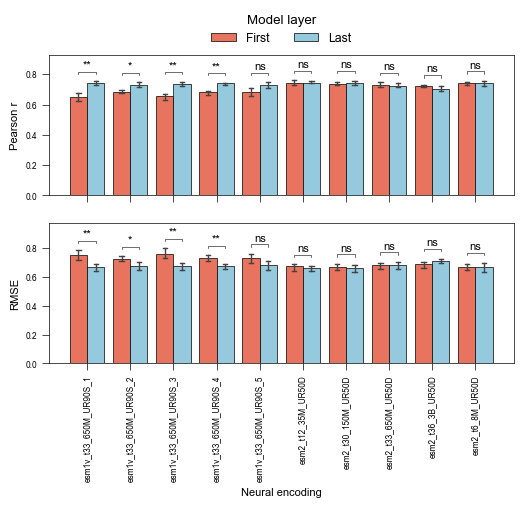

In [20]:
pairs = [
    (('esm1v_t33_650M_UR90S_1', 'First'), ('esm1v_t33_650M_UR90S_1', 'Last')),
    (('esm1v_t33_650M_UR90S_2', 'First'), ('esm1v_t33_650M_UR90S_2', 'Last')),
    (('esm1v_t33_650M_UR90S_3', 'First'), ('esm1v_t33_650M_UR90S_3', 'Last')),
    (('esm1v_t33_650M_UR90S_4', 'First'), ('esm1v_t33_650M_UR90S_4', 'Last')),
    (('esm1v_t33_650M_UR90S_5', 'First'), ('esm1v_t33_650M_UR90S_5', 'Last')),
    (('esm2_t6_8M_UR50D', 'First'), ('esm2_t6_8M_UR50D', 'Last')),
    (('esm2_t12_35M_UR50D', 'First'), ('esm2_t12_35M_UR50D', 'Last')),
    (('esm2_t30_150M_UR50D', 'First'), ('esm2_t30_150M_UR50D', 'Last')),
    (('esm2_t33_650M_UR50D', 'First'), ('esm2_t33_650M_UR50D', 'Last')),
    (('esm2_t36_3B_UR50D', 'First'), ('esm2_t36_3B_UR50D', 'Last')),
]

fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(6,4),sharex=True)
g = sns.barplot(data=esm_df,x='params',y='pearson_r',ax=axes[0],palette=['tomato','skyblue'],errwidth=1,capsize=0.1,hue='is_first_layer',hue_order=['First','Last'],linewidth=0.5,edgecolor='black')
g.set(ylabel='Pearson r',xlabel=None)
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title='Model layer', frameon=False,
)

annotator = Annotator(axes[0], pairs, data=esm_df, x='params', y='pearson_r', hue='is_first_layer', hue_order=['First', 'Last'])
annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0,line_width=0.5,)
annotator.apply_and_annotate()

g = sns.barplot(data=esm_df,x='params',y='rmse',ax=axes[1],palette=['tomato','skyblue'],errwidth=1,capsize=0.1,hue='is_first_layer',hue_order=['First','Last'],linewidth=0.5,edgecolor='black')
g.set(xlabel='Neural encoding',ylabel='RMSE')
g.legend().remove()

annotator = Annotator(axes[1], pairs, data=esm_df, x='params', y='pearson_r', hue='is_first_layer', hue_order=['First', 'Last'])
annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1,line_width=0.5,)
annotator.apply_and_annotate()

plt.xticks(rotation=90)
if SAVE_FIGURES:
    fig.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-neural_encodings.png',dpi=400,transparent=False,bbox_inches='tight')

In [ ]:
esm_df.drop(columns=['is_first_layer','state']).query('layer != "0"').groupby(['params','layer']).mean().style

,,pearson_r,rmse
params,layer,,
esm1v_t33_650M_UR90S_1,33,0.740158,0.668861
esm1v_t33_650M_UR90S_2,33,0.731679,0.678285
esm1v_t33_650M_UR90S_3,33,0.734148,0.677540
esm1v_t33_650M_UR90S_4,33,0.739477,0.673630
esm1v_t33_650M_UR90S_5,33,0.727680,0.685316
esm2_t12_35M_UR50D,12,0.744215,0.663999
esm2_t30_150M_UR50D,30,0.744202,0.664385
esm2_t33_650M_UR50D,33,0.725295,0.685870
esm2_t36_3B_UR50D,36,0.705526,0.708112
